In [ ]:
#!pip install --quiet tqdm

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm import tqdm

In [8]:
pwd

'/home/jovyan/capstone-52/topic_modeling_experiments/classifiers'

In [9]:
cd ../../../capstone-52/Pickled_from_mongo/

/home/jovyan/capstone-52/Pickled_from_mongo


In [10]:
df = pd.read_pickle('../Pickled_from_mongo/combined_eg_gulf_300k_sample.p')

In [11]:
df = df.drop(['_id', 'cleaned_geo', 'cleaned_name'], axis=1)

In [12]:
df.shape

(302938, 2)

In [13]:
df.head()

,cleaned_text,class
0,أزاي أقول لك كنا زمان والماضي كان فى الغيب بكر...,EG
1,هي آراء آه بس أزاي أجويرو منتهي يعني أمال لو م...,EG
2,أنت صيني أزاي تقارن شادي بالخطيب ألي هو الوحيد...,EG
3,أزاي الناس كانت بتغرد في الخمسينات قبل إختراع ...,EG
4,التوينز اللي معاها كل الحلو والوحش والمصايب وا...,EG


In [14]:
stop_words_df = pd.read_pickle('/home/jovyan/capstone-52/topic_modeling_experiments/pickled_stopwords/comp_study_stopwords.p')

In [15]:
stop_words_df.columns = ["stop_words"]

In [16]:
iabuelkhair_stopwords = stop_words_df['stop_words'].tolist()

In [17]:
iabuelkhair_stopwords[:7]

['انها', 'اثناء', 'اجل', 'احدا', 'احدى', 'احيانا', 'اخرى']

## Label Encode the Classes

In [18]:
le = LabelEncoder()
df['class_numerical'] = le.fit_transform(df['class'])

## Ridge Classifier

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['class_numerical'], random_state = 42)

In [20]:
X_train.iloc[8]

'يارب أيام جميله وأخبار مفرحه وشعور جمّيل ونفس مقتنعه وقلب مرتاح وراحة بال وتوفيق من عندك'

In [21]:
params = [(ngr, mindf, maxdf, alpha)
          for ngr in [(1,2)]
          for mindf in [1,8]
          for maxdf in np.linspace(.95,.999,1)
          for alpha in np.logspace(-1,3,1)
         ]

skfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

results_list = []

for ngr, mindf, maxdf, alpha in tqdm(params):
    results = {
        'ngram_range' : ngr,
        'min_df' : mindf,
        'max_df' : maxdf,
        'alpha' : alpha
    }
    train_scores = list()
    val_scores = list()
    
    for train_indices, val_indices in skfold.split(X_train.astype('str'), y_train):
        
        X_train_kf, y_train_kf = X_train.iloc[train_indices], y_train.iloc[train_indices]
        X_val_kf, y_val_kf = X_train.iloc[val_indices], y_train.iloc[val_indices]
        
        ridge_clf_pipe = Pipeline([
                                ('tfidf', TfidfVectorizer(ngram_range=ngr, min_df=mindf, max_df=maxdf, stop_words=iabuelkhair_stopwords)),
                                ('svd', TruncatedSVD(50)),
                                ('clf', RidgeClassifier(alpha=alpha))
                            ])
        
        ridge_clf_pipe.fit(X_train_kf, y_train_kf)
        
        train_scores.append(ridge_clf_pipe.score(X_train_kf, y_train_kf))
        val_scores.append(ridge_clf_pipe.score(X_val_kf, y_val_kf))
        
    results['mean_train_score'] = np.mean(train_scores)
    results['mean_val_score'] = np.mean(val_scores)
    results_list.append(results)

cv_results = pd.DataFrame(results_list)

cv_results.sort_values('mean_val_score', ascending=False, inplace=True)

alpha, maxdf, _, _, mindf, ngr = cv_results.iloc[0].values

cv_results.head()

  0%|          | 0/2 [00:00<?, ?it/s]


MemoryError: 

In [ ]:
ridge_clf_pipe = Pipeline([
                        ('tfidf', TfidfVectorizer(ngram_range=ngr, min_df=mindf, max_df=maxdf)),
                        ('svd', TruncatedSVD(100)),
                        ('clf', RidgeClassifier(alpha=alpha))
                    ])

ridge_clf_pipe.fit(X_train, y_train)

In [ ]:
ridge_clf_pipe.score(X_train, y_train)

In [ ]:
ridge_clf_pipe.score(X_test, y_test)

In [ ]:
print(classification_report(y_train, ridge_clf_pipe.predict(X_train)))
print(classification_report(y_test, ridge_clf_pipe.predict(X_test)))

In [ ]:
ridge_clf_predictions = ridge_clf_pipe.predict(X_test)

In [ ]:
confmat = confusion_matrix(y_test, ridge_clf_predictions)

print(confmat)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, ridge_clf_pipe.predict(X_train)[:,1])

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## SGD Classifier

In [22]:
sgd_clf_pipe = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='modified_huber', penalty='l2',
                                           alpha=1e-3, random_state=42)),
                    ])

sgd_clf_pipe.fit(X_train, y_train)  

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...     penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False))])

In [23]:
x_test_pred_proba = sgd_clf_pipe.predict_proba(X_test)

In [24]:
x_test_pred_proba

array([[ 0.30497802,  0.69502198],
       [ 0.51729151,  0.48270849],
       [ 0.6026077 ,  0.3973923 ],
       ..., 
       [ 0.85128754,  0.14871246],
       [ 0.56943581,  0.43056419],
       [ 0.5366441 ,  0.4633559 ]])

In [25]:
x_test_pred_proba[:5][:]

array([[ 0.30497802,  0.69502198],
       [ 0.51729151,  0.48270849],
       [ 0.6026077 ,  0.3973923 ],
       [ 1.        ,  0.        ],
       [ 0.71865368,  0.28134632]])

In [26]:
X_test_preds_thresh_45 = x_test_pred_proba[:,0] < .45

In [27]:
X_test_preds_thresh_45[:5]

array([ True, False, False, False, False], dtype=bool)

In [28]:
X_test_preds_thresh_45[:5].astype(int)

array([1, 0, 0, 0, 0])

In [29]:
y_test[:5]

46436     1
104133    1
45173     0
12190     0
17651     0
Name: class_numerical, dtype: int64

In [31]:
print(classification_report(y_test, x_test_pred_proba[:,0]<.33))

             precision    recall  f1-score   support

          0       0.62      0.97      0.75     37959
          1       0.92      0.40      0.56     37776

avg / total       0.77      0.68      0.66     75735



In [33]:
confmat = confusion_matrix(y_test, x_test_pred_proba[:,0]<.33)

print(confmat)

[[36680  1279]
 [22578 15198]]


In [34]:
wrong_mask = y_test != (x_test_pred_proba[:,0]<.45).astype(int)

In [48]:
df['misclassified'] = df.filter(items=wrong_mask, axis=0)

ValueError: cannot reindex from a duplicate axis

In [49]:
df_misclassified.head()

NameError: name 'df_misclassified' is not defined

In [36]:
df_misclassified = df_misclassified.rename_axis('misclassified')

NameError: name 'df_misclassified' is not defined

In [38]:
df_misclassified = df_misclassified.set_index('_id', append=True)

NameError: name 'df_misclassified' is not defined

In [39]:
(x_test_pred_proba[:,0]<.45).astype(int)

array([1, 0, 0, ..., 0, 0, 0])

In [40]:
confidence_mask = (x_test_pred_proba[:,0]<.1)|(x_test_pred_proba[:,0]>.6)

In [41]:
x_test_pred_proba[confidence_mask, 0]

array([ 0.6026077 ,  1.        ,  0.71865368, ...,  0.79208586,
        0.8136766 ,  0.85128754])

In [42]:
print(classification_report(y_test[confidence_mask], x_test_pred_proba[confidence_mask,0] < .6))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98     21160
          1       0.95      0.46      0.62      1662

avg / total       0.96      0.96      0.95     22822



In [43]:
confidence_mask

array([False, False,  True, ...,  True, False, False], dtype=bool)

In [44]:
def predict(model, X, threshold):
    proba = model.predict_proba(X)
    return proba[:,0] < threshold

In [45]:
sgd_clf_pipe.score(X_train, y_train)

0.82210182083863326

In [46]:
sgd_clf_pipe.score(X_test, y_test)

0.81857793622499508

In [47]:
print(classification_report(y_train, sgd_clf_pipe.predict(X_train)))
print(classification_report(y_test, sgd_clf_pipe.predict(X_test)))

             precision    recall  f1-score   support

          0       0.91      0.71      0.80    113713
          1       0.76      0.93      0.84    113490

avg / total       0.84      0.82      0.82    227203

             precision    recall  f1-score   support

          0       0.90      0.71      0.80     37959
          1       0.76      0.92      0.84     37776

avg / total       0.83      0.82      0.82     75735



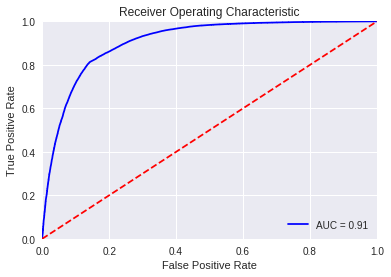

In [42]:
# calculate the fpr and tpr for all thresholds of the classification
probs = x_test_pred_proba
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## MultinomialNB

In [ ]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df['cleaned_text'])
X_train_counts.shape

In [ ]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

In [ ]:
multinomialnb_clf = MultinomialNB().fit(X_train_tfidf, df['class'])

In [ ]:
 df['class'][:4]

In [ ]:
multinomialnb_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),])

In [ ]:
multinomialnb_clf.fit(df['cleaned_text'], df['class'])

In [ ]:
print(classification_report(y_train, multinomialnb_clf.predict(X_train)))
print(classification_report(y_test, multinomialnb_clf.predict(X_test)))

## KNN

In [ ]:
(KNeighborsClassifier(n_neighbors=10), "kNN")

In [86]:
ridge_clf_pipe = Pipeline([
                        ('tfidf', TfidfVectorizer(ngram_range=[(1,2)], min_df=1, stop_words= [iabuelkhair_stopwords], max_df=0.7),
                        ('svd', TruncatedSVD(100)),
                        ('clf', RidgeClassifier()))
                    ])

ridge_clf_pipe.fit(X_train, y_train)

ValueError: too many values to unpack (expected 2)

In [ ]:
from scipy.stats import norm

In [ ]:
norm.pdf()

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

X, y = x_test_pred_proba, y_train


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()